# Model Selection

In Bayesian statistics, an objective model comparison is carried out by comparing the models' [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood). The likelihood function describes the probability (density) of the data, given the parameter values (and thereby the chosen model). By integrating out (marginalizing) the parameter values, one obtains the marginal likelihood (also called the *model evidence*), which directly measures the fitness of the model at hand. The model evidence represents a powerful tool for model selection, as it does not assume specific distributions (e.g. [Student's t-test](https://en.wikipedia.org/wiki/Student's_t-test) assumes Gaussian distributed variables) and automatically follows the principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor).

The forward-backward algorithm that *bayesloop* allows to approximate the model evidence based on the discretized parameter distributions. Details on this method in the context of Hidden Markov models can be found [here](http://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf).

This section aims at giving a very brief introduction of Bayes factors together with an example based on the coal mining data and further introduces combined transition models in *bayesloop*.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting
import seaborn as sns           # nicer plots
sns.set_style('whitegrid')      # plot styling

import numpy as np
import bayesloop as bl

# prepare study for coal mining data
S = bl.Study()
S.loadExampleData()
S.setObservationModel(bl.om.Poisson('accident rate', bl.oint(0, 6, 1000)))

+ Created new study.
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['accident rate']


## Bayes factors

Instead of interpreting the value of the marginal likelihood for a single model, it is common to compare two competing models/explanations $M_1$ and $M_2$ by evaluating the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor), here denoted as $B_{12}$. The Bayes factor is given by the ratio of the two marginal likelihood values:

$$B_{12} = \frac{p(D|M_1)}{p(D|M_2)}$$

where $p(D|M_i)$ states the probability of the data (marginal likelihood) given model $M_i$. A value of $B_{12} > 1$ therefore indicates that the data is better explained by model $M_1$, compared to $M_2$. More detailed information for the interpretation of the value of Bayes factors can be found [here](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation) and in the references therein.

As a first example, we investigate whether the inferred disaster rate of the coal mining data set indeed should be modeled as a time-varying parameter (a constant rate is an equally valid hypothesis). We first fit the model using the `GaussianRandomWalk` transition model with a standard deviation of $\sigma = 0.2$ to determine the corresponding model evidence (on a log scale). Subsequently, we use the simpler `Static` transition model (assuming no change of the disaster rate over time) and compare the resulting model evidence by computing the Bayes factor. Note that for computational efficiency, the keyword argument `evidenceOnly=True` is used, which evaluates the model evidence, but does not store any results for plotting.

In [2]:
# dynamic disaster rate
T = bl.transitionModels.GaussianRandomWalk('sigma', 0.2, target='accident rate')
S.setTransitionModel(T)
S.fit(evidenceOnly=True)

dynamicLogEvidence = S.logEvidence

#static disaster rate
T = bl.transitionModels.Static()
S.setTransitionModel(T)
S.fit(evidenceOnly=True)

staticLogEvidence = S.logEvidence

# determine Bayes factor
B = np.exp(dynamicLogEvidence - staticLogEvidence)
print '\nBayes factor: B =', B

+ Transition model: Gaussian random walk. Hyper-Parameter(s): ['sigma']
+ Started new fit:
    + Formatted data.
    + Set prior (function): jeffreys
    + Finished forward pass.
    + Log10-evidence: -74.59055
+ Transition model: Static/constant parameter values. Hyper-Parameter(s): []
+ Started new fit:
    + Formatted data.
    + Set prior (function): jeffreys
    + Finished forward pass.
    + Log10-evidence: -88.00564

Bayes factor: B = 2.60066520417e+13


The computed Bayes factor $B = 2.6 \cdot 10^{13}$ shows [decisive](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation) support for the first hypothesis of a dynamic disaster rate.

While this analysis conducted above clearly rules for a time-varying rate, there may still exist a dynamic model that represents a better fit than the Gaussian random walk with $\sigma=0.2$. A very simple dynamic model is given by the transition model `ChangePoint` that assumes an abrupt change of the disaster rate at a predefined point in time, we choose 1890 here. Note that the transition model `ChangePoint` does not need a `target` parameter, as it is applied to all parameters of an observation model. We perform a full fit in this case, as we want to provide a plot of the result. 

+ Transition model: Change-point. Hyper-Parameter(s): ['tChange']
+ Started new fit:
    + Formatted data.
    + Set prior (function): jeffreys
    + Finished forward pass.
    + Log10-evidence: -74.41178
    + Finished backward pass.
    + Computed mean parameter values.

Bayes factor: B = 1.50929883739


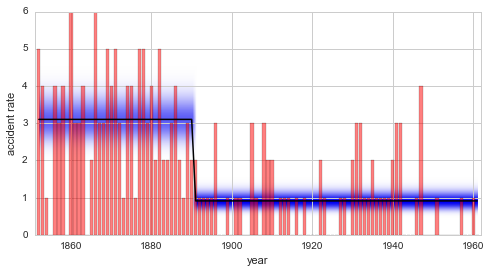

In [3]:
# dynamic disaster rate (change-point model)
T = bl.tm.ChangePoint('tChange', 1890)
S.setTransitionModel(T)
S.fit()

dynamicLogEvidence2 = S.logEvidence

# determine Bayes factor
B = np.exp(dynamicLogEvidence2 - dynamicLogEvidence)
print '\nBayes factor: B =', B

plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution('accident rate')
plt.xlim([1851, 1962])
plt.xlabel('year')

The Bayes factor shows support in favor of the new change-point model. There is a 50% increased probability that the data is generated by the change-point model, compared to the Gaussian random walk model. Some may however argue that the value of $B = 1.5$ indicates only very weak support and is [not worth more than a bare mention](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation). Based on the data at hand, no clear decision between the two models can be made. While the change-point model is favored because it is more restricted (the number of possible data sets that can be decribed by this model is much smaller than for the Gaussian random walk) and therefore *"simpler"*, it cannot capture fluctuations of the disaster rate before and after 1890 like the Gaussian random walk model does.

## Combined transition models

The discussion above shows that depending on the data set, different transition models better explain different aspects of the data. For some data sets, a satisfactory transition model may only be found by combining several simple transition models. *bayesloop* provides a transition model class called `CombinedTransitionModel` that can be supplied with a sequence of transition models that are subsequently applied at every time step. Here, we combine the change-point model and the Gaussian random walk model to check whether the combined model yields a better explanation of the data, compared to the change-point model alone:

+ Transition model: Combined transition model. Hyper-Parameter(s): ['tChange', 'sigma']
+ Started new fit:
    + Formatted data.
    + Set prior (function): jeffreys
    + Finished forward pass.
    + Log10-evidence: -74.01460
    + Finished backward pass.
    + Computed mean parameter values.

Bayes factor: B = 2.49563205383


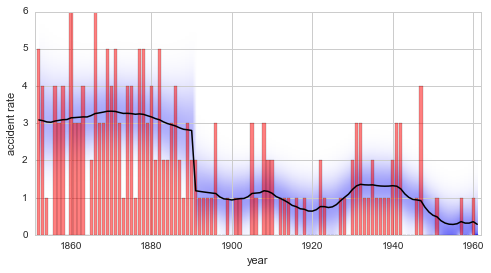

In [4]:
# combined model (change-point model + Gaussian random walk)
T = bl.tm.CombinedTransitionModel(bl.tm.ChangePoint('tChange', 1890),
                                  bl.tm.GaussianRandomWalk('sigma', 0.2, target='accident rate'))
S.setTransitionModel(T)
S.fit()

combinedLogEvidence = S.logEvidence

# determine Bayes factor
B = np.exp(combinedLogEvidence - dynamicLogEvidence2)
print '\nBayes factor: B =', B

plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution('accident rate')
plt.xlim([1851, 1962])
plt.xlabel('year')

Again, the refined model is favored by a Bayes factor of $B = 2.5$.

## Serial transition model

The combined transition models introduced above substantially extend the number of different transition models. These transition models imply identical parameter dynamics for all time steps. In many applications, however, there exist so-called structural breaks when parameter dynamics exhibit a fundamental change. In contrast to an abrupt change of the parameter values in case of a change-point, a structural break indicates an abrupt change of the transition model at a specific point in time. The class `SerialTransitionModel` allows to define a sequence of transition models (including combined transition models) together with a sequence of time steps that denote the structural breaks. Each break-point is defined just like any other transition model, containing a unique name and a time stamp (or an array of possible time stamps, see [this tutorial](changepointstudy.html) on change-point studies). Note, however, that the `BreakPoint` transition model class can only be used as a submodel of an `SerialTransitionModel` instance.

We use this new class of transition model to explore the idea that the number of coal mining disasters did not decrease instantaneously, but instead decreased linearly over the course of a few years. We assume a static disaster rate until 1885, followed by a deterministic decrease of 0.2 disasters per year (determinsitic transition models are defined easily by custom Python functions, see below) until 1895. Finally, the disaster rate after the year 1895 is modelled by a Gaussian random walk of the disaster rate with a standard deviation of $\sigma=0.1$. Note that we pass the transition models and the corresponding structural breaks (time steps) to the `SerialTransitionModel` in turns. While this order may increase readability, one can also pass the models first, followed by the corresponding time steps.

+ Transition model: Serial transition model. Hyper-Parameter(s): ['slope', 'sigma', 't_1', 't_2']
+ Started new fit:
    + Formatted data.
    + Set prior (function): jeffreys
    + Finished forward pass.
    + Log10-evidence: -72.93384
    + Finished backward pass.
    + Computed mean parameter values.

Bayes factor: B = 12.0436384646


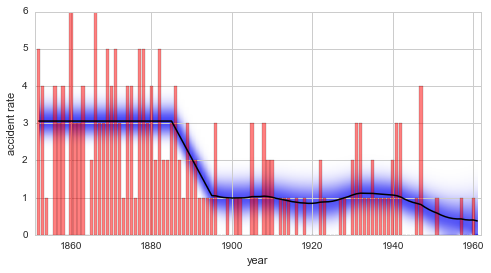

In [5]:
# Definition of a linear decrease transition model.
# The first argument of any determinsitic model must be the time stamp
# and any hyper-parameters of the model are supplied as keyword-arguments.
# The hyper-parameter value(s) is/are supplied as default values.
def linear(t, slope=-0.2):
    return slope*t

T = bl.tm.SerialTransitionModel(bl.tm.Static(),
                                bl.tm.BreakPoint('t_1', 1885),
                                bl.tm.Deterministic(linear, target='accident rate'),
                                bl.tm.BreakPoint('t_2', 1895),
                                bl.tm.GaussianRandomWalk('sigma', 0.1, target='accident rate'))
S.setTransitionModel(T)
S.fit()

serialLogEvidence = S.logEvidence

# determine Bayes factor
B = np.exp(serialLogEvidence - combinedLogEvidence)
print '\nBayes factor: B =', B

plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution('accident rate')
plt.xlim([1851, 1962])
plt.xlabel('year')

The Bayes factor of the serial model compared to the combined model is determined to $B = 12.0$. This value indicates [positive/strong](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation) evidence in favor of the serial model. Keep in mind, though, that the time steps of the structural breaks and the slope of the linear decrease are not inferred in this example, but are instead set by the user. The determined Bayes factor therefore relies on the assumption that these values are true, and the uncertainty tied to these values is therefore not reflected in the value of the Bayes factor. More elaborate studies that take into account the uncertainty tied to these hyper-parameters are introduced [here](hyperstudy.html) and [here](changepointstudy.html).

The iterative approach of creating new hypotheses and comparing them to the best hypothesis currently available provides an objective and never-the-less straight-forward way of exploring new data sets. The subsequent tutorial provides methods to improve upon values for hyper-parameters that are *"blindly"* set by the user.